In [1]:
!pip install foolbox

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from __future__ import print_function
import os
import torch.optim as optim
import foolbox as fb
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD,LinfBasicIterativeAttack,LinfFastGradientAttack,L2CarliniWagnerAttack,LinfDeepFoolAttack,L2DeepFoolAttack,L2PGD
from time import gmtime, strftime
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import datetime
import torch.nn as nn
from __future__ import print_function
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import multiprocessing as mp
from torch.distributions import Categorical
import numpy as np



In [4]:
if not os.path.exists('/content/gdrive/MyDrive/checkpointCIFAR10'):
    os.makedirs('/content/gdrive/MyDrive/checkpointCIFAR10')

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

In [6]:
class LeNet_dropout(nn.Module):

    def __init__(self):
        super(LeNet_dropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(8192, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

        self.drop_layer = nn.Dropout(p=0.50)
        self.drop_layer_conv = nn.Dropout2d(p=0.3)

    def last_hidden_layer_output(self, x):

        x = F.relu(self.conv1(x),inplace=True)
        x = F.max_pool2d(F.relu(self.conv2(x),inplace=True), kernel_size=2, stride=2)

        x = F.relu(self.conv3(x),inplace=True)
        x = self.drop_layer_conv(F.max_pool2d(F.relu(self.conv4(x),inplace=True), kernel_size=2, stride=2))

        x = F.relu(self.conv5(x),inplace=True)
        x = self.drop_layer_conv(F.max_pool2d(F.relu(self.conv6(x),inplace=True), kernel_size=2, stride=2))

        x = x.view(-1, 8192)
        x = self.drop_layer(F.relu(self.fc1(x)))
        x = self.drop_layer(F.relu(self.fc2(x)))
        return x

    def forward(self, x):

        x = self.last_hidden_layer_output(x)
        x = self.fc3(x)
        return x


In [7]:
class MLP(nn.Module):

  def __init__(self):
    super(MLP,self).__init__()
    self.layers = nn.Sequential(

      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 10),
    )

  def forward(self, x):
    return self.layers(x)

In [8]:

def train(model, opt, epoch):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_running_correct = 0
    train_running_loss = 0.0

    model.train()

    lr = opt.param_groups[0]['lr']

    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        opt.zero_grad()
        output = model(data)
        loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        train_running_loss += loss.item()
        loss.backward()
        opt.step()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()

    train_loss = train_running_loss / len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_loader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Epoch: {epoch}, LR: {lr:.5f}')

def test(model):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.eval()

    test_loss = 0
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        test_loss += F.nll_loss(F.log_softmax(output, dim=1), target, size_average=False).data# sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def mcdropout_test(model):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.eval()

    enable_dropout(model)
    test_loss = 0
    correct = 0
    T = 50

    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        output_list = []

        for i in range(T):
            output_list.append(torch.unsqueeze(model(data), 0))

        output_mean = torch.cat(output_list, 0).mean(0)
        test_loss += F.nll_loss(F.log_softmax(output_mean, dim=1), target, size_average=False).data  # sum up batch loss
        pred = output_mean.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def noise(x, eps, clip_min, clip_max):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    eta = torch.FloatTensor(*x.shape).normal_(mean=0,std=eps)
    eta = eta.to(device)
    adv_x = x + eta
    if clip_min is not None and clip_max is not None:
        adv_x = torch.clamp(adv_x, min=clip_min, max=clip_max)
    return adv_x

def predict_uncertainties(model, image, T=50):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image = image.to(device)

    #torch.manual_seed(2)

    image = image.detach()
    item_count = image.shape[0]

    enable_dropout(model)
    model.train()

    dropout_predictions = torch.zeros([T, item_count, 10])

    for t in range(T):

        enable_dropout(model)
        model.train()

        with torch.no_grad():
            output = model(image)

        output_prob = F.softmax(output, dim=1) #shape is 1x10 if item_count is 1 (only one image in input batch)
        dropout_predictions[t] = output_prob

    #dropout_predictions is of shape 50xitem_countx10

    # print("dropout predictions shape", dropout_predictions.shape)

    mean = torch.mean(dropout_predictions, dim=0)

    entropy = Categorical(probs=mean).entropy()

    pred_mean = mean

    aleatoric = torch.zeros([item_count,10,10])
    epistemic = torch.zeros([item_count,10,10])

    for t in range(T):

        pred_t = dropout_predictions[t]

        aleatoric += torch.diag_embed(pred_t, offset=0, dim1=-2, dim2=-1) - pred_t[:, :, None] @ pred_t[:, None, :]
        epistemic += (pred_t - pred_mean)[:, :, None] @ (pred_t - pred_mean)[:, None, :]

    aleatoric = aleatoric / T #both of them are of shape item_count x 10x10
    epistemic = epistemic / T #both of them are of shape item_count x 10x10

    # print("aleatoric.shape", aleatoric.shape)
    # print("aleatoric.diag.shape", torch.diagonal(aleatoric, 0, dim1=-2, dim2=-1).shape)

    aleatoric = torch.diagonal(aleatoric, 0, dim1=-2, dim2=-1)
    epistemic = torch.diagonal(epistemic, 0, dim1=-2, dim2=-1)

    aleatoric = torch.mean(aleatoric,1,True)
    epistemic = torch.mean(epistemic, 1, True)

    scibilic = epistemic / aleatoric

    scibilic[torch.isnan(scibilic)] = 0

    model.eval()

    return aleatoric.transpose_(0, 1)[0], epistemic.transpose_(0, 1)[0], scibilic.transpose_(0, 1)[0], entropy

def calculate_distance(model, predictions, last_hidden_layer_outs):

    model.eval()

    total = []

    for z in range(last_hidden_layer_outs.shape[0]):

        hidden_tensor = torch.from_numpy(last_hidden_layer_outs[z])

        hidden_tensor = hidden_tensor.to(device)

        hidden_tensor = torch.unsqueeze(hidden_tensor, 0)

        total.append(F.softmax(model(hidden_tensor) / 1, dim=1)[0][predictions[z].item()])

    return torch.Tensor(total)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001
epoch = 75

model_dropout = LeNet_dropout()
model_dropout = model_dropout.to(device)

optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=learning_rate)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 15 epochs"""
    lr = learning_rate * (0.5 ** (epoch // 15))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:

print("Press 0, 1, 2 , 3 , 4 , 5 :\ntrain mode (0)\ntest set uncertainty metrics for correct and wrong predictions (1)\nPrepare Last Hidden Layer Outputs (2)\nTrain MLP (3)\nPrepare Data (4)\nPlot Performances (5)\n")

input_a = int(input())

Press 0, 1, 2 , 3 , 4 , 5 :
train mode (0)
test set uncertainty metrics for correct and wrong predictions (1)
Prepare Last Hidden Layer Outputs (2)
Train MLP (3)
Prepare Data (4)
Plot Performances (5)

5


In [11]:
if input_a == 0:
    
    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())

    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

    print ('Train Lenet with dropout at all layer')
    for epoch in range(1, epoch + 1):
        adjust_learning_rate(optimizer_dropout, epoch)
        train(model_dropout, optimizer_dropout, epoch)
        test(model_dropout)

    print("Test Set results of dropout model")
    test(model_dropout)
    #print("MC Dropout Test Results of dropout model")
    #mcdropout_test(model_dropout)

    print('Save /content/gdrive/MyDrive/checkpointCIFAR10/' + 'LeNet_dropout' + '.pth.tar')
    state = {'state_dict': model_dropout.state_dict()}
    filename = '/content/gdrive/MyDrive/checkpointCIFAR10/' + 'LeNet_dropout' + '.pth.tar'
    torch.save(state, filename)

In [12]:
if input_a == 1:

    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    ckpt_dropout = torch.load('/content/gdrive/MyDrive/checkpointCIFAR10/LeNet_dropout.pth.tar')
    model_dropout.load_state_dict(ckpt_dropout['state_dict'])
    model_dropout.eval()
    model_dropout = model_dropout.to(device)

    print("Beginning time is : ")
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    first_time = datetime.datetime.now()

    al_clean_tensor_corrects = torch.empty(0)
    ep_clean_tensor_corrects = torch.empty(0)
    sc_clean_tensor_corrects = torch.empty(0)
    ent_clean_tensor_corrects = torch.empty(0)

    al_clean_tensor_wrongs = torch.empty(0)
    ep_clean_tensor_wrongs = torch.empty(0)
    sc_clean_tensor_wrongs = torch.empty(0)
    ent_clean_tensor_wrongs = torch.empty(0)

    a = 0

    for test_images, test_labels in test_loader:

        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        model_dropout.eval()
        sample_image = test_images
        sample_label = test_labels
        outputs = model_dropout(test_images)
        corrects = (outputs.max(dim=1)[1] == test_labels)
        wrongs = (outputs.max(dim=1)[1] != test_labels)

        sample_image_corrects = sample_image[corrects]
        sample_label_corrects = sample_label[corrects]

        sample_image_wrongs = sample_image[wrongs]
        sample_label_wrongs = sample_label[wrongs]


        al_clean_corrects, ep_clean_corrects, sc_clean_corrects, ent_clean_corrects = predict_uncertainties(model_dropout, sample_image_corrects, 50)

        al_clean_tensor_corrects = torch.cat([al_clean_tensor_corrects, al_clean_corrects])
        ep_clean_tensor_corrects = torch.cat([ep_clean_tensor_corrects, ep_clean_corrects])
        sc_clean_tensor_corrects = torch.cat([sc_clean_tensor_corrects, sc_clean_corrects])
        ent_clean_tensor_corrects = torch.cat([ent_clean_tensor_corrects, ent_clean_corrects])

        if sample_image_wrongs.shape[0] != 0:

            al_clean_wrongs, ep_clean_wrongs, sc_clean_wrongs, ent_clean_wrongs = predict_uncertainties(model_dropout, sample_image_wrongs, 50)

            al_clean_tensor_wrongs = torch.cat([al_clean_tensor_wrongs, al_clean_wrongs])
            ep_clean_tensor_wrongs = torch.cat([ep_clean_tensor_wrongs, ep_clean_wrongs])
            sc_clean_tensor_wrongs = torch.cat([sc_clean_tensor_wrongs, sc_clean_wrongs])
            ent_clean_tensor_wrongs = torch.cat([ent_clean_tensor_wrongs, ent_clean_wrongs])

    print("PREPARING CLEAN DATA FOR CORRECTS....")
    al_clean_tensor_corrects, ep_clean_tensor_corrects, sc_clean_tensor_corrects, ent_clean_tensor_corrects = al_clean_tensor_corrects.numpy(), ep_clean_tensor_corrects.numpy(), sc_clean_tensor_corrects.numpy(), ent_clean_tensor_corrects.numpy()
    print("Done....")

    print("PREPARING CLEAN DATA FOR WRONGS...")
    al_clean_tensor_wrongs, ep_clean_tensor_wrongs, sc_clean_tensor_wrongs, ent_clean_tensor_wrongs = al_clean_tensor_wrongs.numpy(), ep_clean_tensor_wrongs.numpy(), sc_clean_tensor_wrongs.numpy(), ent_clean_tensor_wrongs.numpy()
    print("Done....")

    print("\nMean of the aleatoric uncertainty values for all the errors : ", al_clean_tensor_wrongs.mean())
    print("Mean of the aleatoric uncertainty values for all the corrects ", al_clean_tensor_corrects.mean())

    print("\nMean of the epistemic uncertainty values for all the errors : ", ep_clean_tensor_wrongs.mean())
    print("Mean of the epistemic uncertainty values for all the corrects ", ep_clean_tensor_corrects.mean())

    print("\nMean of the scibilic uncertainty values for all the errors : ", sc_clean_tensor_wrongs.mean())
    print("Mean of the scibilic uncertainty values for all the corrects ", sc_clean_tensor_corrects.mean())

    print("\nMean of the entropy values for all the errors : ", ent_clean_tensor_wrongs.mean())
    print("Mean of the entropy values for all the corrects ", ent_clean_tensor_corrects.mean())

In [13]:
if input_a == 2:

    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())

    train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    norm = Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    preprocessing = dict(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261], axis=-3)

    model_attack = LeNet_dropout()
    ckpt_attack = torch.load('/content/gdrive/MyDrive/checkpointCIFAR10/LeNet_dropout.pth.tar')
    model_attack.load_state_dict(ckpt_attack['state_dict'])
    model_attack.eval()
    model_attack = model_attack.to(device)

    last_hidden_idx = -4
    output_dim = list(model_attack.children())[last_hidden_idx].out_features
    print(output_dim)

    ################ CLEAN LAST HIDDEN LAYER OUTPUTS ####################
    last_hidden_layer_outputs = np.empty((0, output_dim))
    predss = np.empty((0))
    labelss = np.empty((0))

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        with torch.no_grad():
            output = model_attack(image)

        pred = output.data.max(1, keepdim=True)[1]
        pred = pred.view_as(label)
        predss = np.hstack((predss, pred.detach().cpu().numpy()))
        labelss = np.hstack((labelss, label.cpu().numpy()))

        last_hidden_layer_outputs = np.vstack(
            (last_hidden_layer_outputs, model_attack.last_hidden_layer_output(image).detach().cpu().numpy()))

    inds_correct = np.where(predss == labelss)[0]

    predss = predss[inds_correct]
    labelss = labelss[inds_correct]
    last_hidden_layer_outputs = last_hidden_layer_outputs[inds_correct]

    ################ ADVERSARIAL LAST HIDDEN LAYER OUTPUTS ####################

    adv_last_hidden_layer_outputs = np.empty((0, output_dim))

    model_attack.eval()
    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        attack = LinfBasicIterativeAttack()
        fmodel = PyTorchModel(model_attack, bounds=(0, 1))
        raw_advs, clipped_advs, success = attack(fmodel, image, label, epsilons=[0.03])
        pert = torch.tensor(clipped_advs[0])

        with torch.no_grad():
            adv_last_hidden_layer_outputs = np.vstack(
                (adv_last_hidden_layer_outputs, model_attack.last_hidden_layer_output(pert).cpu().numpy()))

    adv_last_hidden_layer_outputs = adv_last_hidden_layer_outputs[inds_correct]

    ################ NOSIY LAST HIDDEN LAYER OUTPUTS ####################

    noisy_last_hidden_layer_outputs = np.empty((0, output_dim))

    model_attack.eval()
    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        noisy_image = noise(image, 0.03, 0, 1)

        with torch.no_grad():
            noisy_last_hidden_layer_outputs = np.vstack(
                (noisy_last_hidden_layer_outputs, model_attack.last_hidden_layer_output(noisy_image).cpu().numpy()))

    noisy_last_hidden_layer_outputs = noisy_last_hidden_layer_outputs[inds_correct]

    ###############

    dig_outputs = {}
    dig_outputs_raw = {}
    dig_labels = {}
    dig_labels_raw = {}
    dig_outputs_adv = {}
    dig_outputs_adv_raw = {}
    dig_outputs_noisy = {}
    dig_outputs_noisy_raw = {}

    for i in range(10):
        inds_i = np.where(predss == i)[0]

        dig_outputs_raw[i] = last_hidden_layer_outputs[inds_i]
        dummy = dig_outputs_raw[i].copy()

        dig_labels_raw[i] = labelss[inds_i]
        dummy_labels = dig_labels_raw[i].copy()

        dig_outputs_adv_raw[i] = adv_last_hidden_layer_outputs[inds_i]
        dummy_adv = dig_outputs_adv_raw[i].copy()

        dig_outputs_noisy_raw[i] = noisy_last_hidden_layer_outputs[inds_i]
        dummy_noisy = dig_outputs_noisy_raw[i].copy()

        rows = dummy.shape[0]

        dig_outputs[i] = dummy
        dig_labels[i] = dummy_labels
        dig_outputs_adv[i] = dummy_adv
        dig_outputs_noisy[i] = dummy_noisy

    for i in range(10):
        filename = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_outputs_' + str(i) + '.npy'
        np.save(filename, dig_outputs[i])

        filename2 = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_labels_' + str(i) + '.npy'
        np.save(filename2, dig_labels[i])

        filename3 = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_outputs_adv_' + str(i) + '.npy'
        np.save(filename3, dig_outputs_adv[i])

        filename4 = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_outputs_noisy' + str(i) + '.npy'
        np.save(filename4, dig_outputs_noisy[i])


In [14]:
if input_a == 3:

    my_mlp_model = MLP()
    my_mlp_model = my_mlp_model.to(device)

    model_attack_new = LeNet_dropout()
    ckpt_attack_new = torch.load('/content/gdrive/MyDrive/checkpointCIFAR10/LeNet_dropout.pth.tar')
    model_attack_new.load_state_dict(ckpt_attack_new['state_dict'])
    model_attack_new.eval()
    model_attack_new = model_attack_new.to(device)

    dig_labels = {}
    dig_outputs = {}
    dig_outputs_adv = {}
    dig_outputs_noisy = {}

    data = np.empty((0, 256))
    labels = np.empty((0, 1))

    for i in range(10):
        filename = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_outputs_' + str(i) + '.npy'
        dig_outputs[i] = np.load(filename)

        filename3 = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_outputs_adv_' + str(i) + '.npy'
        dig_outputs_adv[i] = np.load(filename3)

        filename4 = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_outputs_noisy' + str(i) + '.npy'
        dig_outputs_noisy[i] = np.load(filename4)

        filename2 = '/content/gdrive/MyDrive/checkpointCIFAR10/dig_labels_' + str(i) + '.npy'
        dig_labels[i] = np.load(filename2)

        dig_labels[i] = np.expand_dims(dig_labels[i], axis=1)

        data = np.vstack((data, dig_outputs[i]))
        data = np.vstack((data, dig_outputs_adv[i]))
        data = np.vstack((data, dig_outputs_noisy[i]))
        labels = np.vstack((labels, dig_labels[i]))
        labels = np.vstack((labels, dig_labels[i]))
        labels = np.vstack((labels, dig_labels[i]))

    labels = np.squeeze(labels, axis=1)

    print("labels shape ", labels.shape)
    print("data shape ", data.shape)

    train_data = []
    for i in range(len(data)):
        train_data.append([data[i], labels[i]])

    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=128)

    my_mlp_model.train()

    lr = 0.001
    opt = optim.Adam(my_mlp_model.parameters(), lr=lr)
    T = 1

    my_mlp_model.train()

    for epoch in range(180):

        total_err = 0

        for batch_idx, (data, target) in enumerate(train_loader):

            data = data.to(device)
            target = target.to(device)

            data = data.float()
            target = target.long()
            opt.zero_grad()

            output = my_mlp_model(data)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()
            opt.step()
            total_err += (output.max(dim=1)[1] != target).sum().item()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)] lr: {}\tLoss: {:.6f}'
                      .format(epoch, batch_idx * len(data),
                              len(train_loader.dataset),
                              100. * batch_idx / len(train_loader),
                              lr, loss.data))
        print('*******Train Epoch: {} error is {}'.format(epoch + 1, total_err))

    my_mlp_model.eval()
    print('Save /content/gdrive/MyDrive/checkpointCIFAR10/' + 'MLP_Modell' + '.pth.tar')
    state = {'state_dict': my_mlp_model.state_dict()}
    filename = '/content/gdrive/MyDrive/checkpointCIFAR10/' + 'MLP_Modell' + '.pth.tar'
    torch.save(state, filename)

    my_mlp_model_2 = MLP()
    ckpt_dropout = torch.load('/content/gdrive/MyDrive/checkpointCIFAR10/MLP_Modell.pth.tar')
    my_mlp_model_2.load_state_dict(ckpt_dropout['state_dict'])
    my_mlp_model_2.eval()


In [15]:
if input_a == 4:

    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    ckpt_dropout = torch.load('/content/gdrive/MyDrive/checkpointCIFAR10/LeNet_dropout.pth.tar')
    model_dropout.load_state_dict(ckpt_dropout['state_dict'])
    model_dropout.eval()
    model_dropout = model_dropout.to(device)

    my_mlp_model_2 = MLP()
    ckpt_dropout = torch.load('/content/gdrive/MyDrive/checkpointCIFAR10/MLP_Modell.pth.tar')
    my_mlp_model_2.load_state_dict(ckpt_dropout['state_dict'])
    my_mlp_model_2.eval()
    my_mlp_model_2 = my_mlp_model_2.to(device)


    print("Chose attack type: \nDeepfool (1)\nFGSM  (2)\nBIM  (3)\nCW  (4)\nPGD  (5)\n")

    input_c = int(input())

    print("Enter epsilon value : \n")

    eps = float(input())
    eps_str = str(int((eps + 0.0000001) * 100))

    if input_c == 1:
        attack = LinfDeepFoolAttack()
        fmodel = PyTorchModel(model_dropout, bounds=(0, 1))
        attack_type = "Deepfool"
        eps_noisy = eps
    elif input_c == 2:
        attack = LinfFastGradientAttack()
        fmodel = PyTorchModel(model_dropout, bounds=(0, 1))
        attack_type = "FGSM"
        eps_noisy = eps
    elif input_c == 3:
        attack = LinfBasicIterativeAttack()
        fmodel = PyTorchModel(model_dropout, bounds=(0, 1))
        attack_type = "BIM"
        eps_noisy = eps
    elif input_c == 4:

        if eps == 0.02:
            eps = 0.532 #############################################################
            eps_noisy = 0.02
        if eps == 0.03:
            eps = 0.798 #############################################################
            eps_noisy = 0.03 
        if eps == 0.04:
            eps = 1.064 #############################################################
            eps_noisy = 0.04 
        print(eps)
        attack = L2CarliniWagnerAttack(steps=1000)
        fmodel = PyTorchModel(model_dropout, bounds=(0, 1))
        attack_type = "CW"
    elif input_c == 5:
        attack = LinfPGD()
        fmodel = PyTorchModel(model_dropout, bounds=(0, 1))
        attack_type = "PGD"
        eps_noisy = eps

    print("Chosen attack type is ", attack_type)
    print("Chosen epsilon is ", eps)

    print("Prepared data will be stored at: ")
    print(f"/content/gdrive/MyDrive/checkpointCIFAR10/all_numpy_{attack_type}_0{eps_str}.npy")

    print("Beginning time is : ")
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    first_time = datetime.datetime.now()

    al_clean_tensor = torch.empty(0)
    ep_clean_tensor = torch.empty(0)
    sc_clean_tensor = torch.empty(0)
    ent_clean_tensor = torch.empty(0)
    preds_clean_tensor = torch.empty(0)
    distances_clean_tensor = torch.empty(0)

    al_noisy_tensor = torch.empty(0)
    ep_noisy_tensor = torch.empty(0)
    sc_noisy_tensor = torch.empty(0)
    ent_noisy_tensor = torch.empty(0)
    preds_noisy_tensor = torch.empty(0)
    distances_noisy_tensor = torch.empty(0)

    al_dirty_tensor = torch.empty(0)
    ep_dirty_tensor = torch.empty(0)
    sc_dirty_tensor = torch.empty(0)
    ent_dirty_tensor = torch.empty(0)
    preds_dirty_tensor = torch.empty(0)
    distances_dirty_tensor = torch.empty(0)

    preds_clean_tensor = preds_clean_tensor.to(device)
    preds_noisy_tensor = preds_noisy_tensor.to(device)
    preds_dirty_tensor = preds_dirty_tensor.to(device)


    for test_images, test_labels in test_loader:

        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        model_dropout.eval()
        sample_image = test_images
        sample_label = test_labels
        outputs = model_dropout(test_images)
        preds = outputs.max(dim=1)[1]
        corrects = (preds == test_labels)
        sample_image = sample_image[corrects]
        sample_label = sample_label[corrects]
        preds = preds[corrects]
        preds = preds.to(device)

        al_clean, ep_clean, sc_clean, ent_clean = predict_uncertainties(model_dropout, sample_image, 50)


        al_clean_tensor = torch.cat([al_clean_tensor, al_clean])
        ep_clean_tensor = torch.cat([ep_clean_tensor, ep_clean])
        sc_clean_tensor = torch.cat([sc_clean_tensor, sc_clean])
        ent_clean_tensor = torch.cat([ent_clean_tensor, ent_clean])
        preds_clean_tensor = torch.cat([preds_clean_tensor, preds])

        model_dropout.eval()
        with torch.no_grad():
            last_hidden_layer_outputs_clean = model_dropout.last_hidden_layer_output(sample_image).detach().cpu().numpy()

        distances_clean = calculate_distance(my_mlp_model_2, preds, last_hidden_layer_outputs_clean)

        distances_clean_tensor = torch.cat([distances_clean_tensor, distances_clean])

#########################

        image_noisy = noise(sample_image, eps_noisy, 0, 1)

        al_noisy, ep_noisy, sc_noisy, ent_noisy = predict_uncertainties(model_dropout, image_noisy, 50)

        al_noisy_tensor = torch.cat([al_noisy_tensor, al_noisy])
        ep_noisy_tensor = torch.cat([ep_noisy_tensor, ep_noisy])
        sc_noisy_tensor = torch.cat([sc_noisy_tensor, sc_noisy])
        ent_noisy_tensor = torch.cat([ent_noisy_tensor, ent_noisy])

        model_dropout.eval()
        outputs_noisy = model_dropout(image_noisy)
        preds_noisy = outputs_noisy.max(dim=1)[1]

        preds_noisy_tensor = torch.cat([preds_noisy_tensor, preds_noisy])


        model_dropout.eval()
        with torch.no_grad():
            last_hidden_layer_outputs_noisy = model_dropout.last_hidden_layer_output(image_noisy).detach().cpu().numpy()

        distances_noisy = calculate_distance(my_mlp_model_2, preds_noisy, last_hidden_layer_outputs_noisy)

        distances_noisy_tensor = torch.cat([distances_noisy_tensor, distances_noisy])

#########################

        raw_advs, clipped_advs, success = attack(fmodel, sample_image, sample_label, epsilons=[eps])
        image_dirty = torch.tensor(clipped_advs[0])

        al_dirty, ep_dirty, sc_dirty, ent_dirty = predict_uncertainties(model_dropout, image_dirty, 50)

        al_dirty_tensor = torch.cat([al_dirty_tensor, al_dirty])
        ep_dirty_tensor = torch.cat([ep_dirty_tensor, ep_dirty])
        sc_dirty_tensor = torch.cat([sc_dirty_tensor, sc_dirty])
        ent_dirty_tensor = torch.cat([ent_dirty_tensor, ent_dirty])

        model_dropout.eval()
        outputs_dirty = model_dropout(image_dirty)
        preds_dirty = outputs_dirty.max(dim=1)[1]

        preds_dirty_tensor = torch.cat([preds_dirty_tensor, preds_dirty])

        model_dropout.eval()
        with torch.no_grad():
            last_hidden_layer_outputs_dirty = model_dropout.last_hidden_layer_output(image_dirty).detach().cpu().numpy()

        distances_dirty = calculate_distance(my_mlp_model_2, preds_dirty, last_hidden_layer_outputs_dirty)

        distances_dirty_tensor = torch.cat([distances_dirty_tensor, distances_dirty])

    #########################

    print("PREPARING CLEAN DATA....")

    al_clean_tensor, ep_clean_tensor, sc_clean_tensor, ent_clean_tensor = al_clean_tensor.cpu().numpy(), ep_clean_tensor.cpu().numpy(), sc_clean_tensor.cpu().numpy(), ent_clean_tensor.cpu().numpy()
    
    zero_clean_tensor = np.zeros_like(al_clean_tensor)

    distances_clean_tensor = distances_clean_tensor.cpu().numpy()

    preds_clean_tensor = preds_clean_tensor.cpu().numpy()

    al_clean_tensor = al_clean_tensor.reshape(al_clean_tensor.shape[0], 1)
    ep_clean_tensor = ep_clean_tensor.reshape(ep_clean_tensor.shape[0], 1)
    sc_clean_tensor = sc_clean_tensor.reshape(sc_clean_tensor.shape[0], 1)
    ent_clean_tensor = ent_clean_tensor.reshape(ent_clean_tensor.shape[0], 1)
    zero_clean_tensor = zero_clean_tensor.reshape(zero_clean_tensor.shape[0], 1)
    preds_clean_tensor = preds_clean_tensor.reshape(preds_clean_tensor.shape[0], 1)
    distances_clean_tensor = distances_clean_tensor.reshape(distances_clean_tensor.shape[0],1)

    clean_tensor_all = np.concatenate((al_clean_tensor,ep_clean_tensor,sc_clean_tensor,ent_clean_tensor,preds_clean_tensor,distances_clean_tensor,zero_clean_tensor),axis=1)
    print("Done....")

    print("PREPARING NOISY DATA....")

    al_noisy_tensor, ep_noisy_tensor, sc_noisy_tensor, ent_noisy_tensor = al_noisy_tensor.cpu().numpy(), ep_noisy_tensor.cpu().numpy(), sc_noisy_tensor.cpu().numpy(), ent_noisy_tensor.cpu().numpy()

    zero_noisy_tensor = np.zeros_like(al_noisy_tensor)

    distances_noisy_tensor = distances_noisy_tensor.cpu().numpy()

    preds_noisy_tensor = preds_noisy_tensor.cpu().numpy()

    al_noisy_tensor = al_noisy_tensor.reshape(al_noisy_tensor.shape[0], 1)
    ep_noisy_tensor = ep_noisy_tensor.reshape(ep_noisy_tensor.shape[0], 1)
    sc_noisy_tensor = sc_noisy_tensor.reshape(sc_noisy_tensor.shape[0], 1)
    ent_noisy_tensor = ent_noisy_tensor.reshape(ent_noisy_tensor.shape[0], 1)
    zero_noisy_tensor = zero_noisy_tensor.reshape(zero_noisy_tensor.shape[0], 1)
    preds_noisy_tensor = preds_noisy_tensor.reshape(preds_noisy_tensor.shape[0], 1)
    distances_noisy_tensor = distances_noisy_tensor.reshape(distances_noisy_tensor.shape[0],1)


    noisy_tensor_all = np.concatenate((al_noisy_tensor,ep_noisy_tensor,sc_noisy_tensor,ent_noisy_tensor,preds_noisy_tensor,distances_noisy_tensor,zero_noisy_tensor),axis=1)
    print("Done....")

    print("PREPARING DIRTY DATA....")

    al_dirty_tensor, ep_dirty_tensor, sc_dirty_tensor, ent_dirty_tensor = al_dirty_tensor.cpu().numpy(), ep_dirty_tensor.cpu().numpy(), sc_dirty_tensor.cpu().numpy(), ent_dirty_tensor.cpu().numpy()

    ones_dirty_tensor = np.ones_like(ep_dirty_tensor)

    distances_dirty_tensor = distances_dirty_tensor.cpu().numpy()

    preds_dirty_tensor = preds_dirty_tensor.cpu().numpy()

    al_dirty_tensor = al_dirty_tensor.reshape(al_dirty_tensor.shape[0], 1)
    ep_dirty_tensor = ep_dirty_tensor.reshape(ep_dirty_tensor.shape[0], 1)
    sc_dirty_tensor = sc_dirty_tensor.reshape(sc_dirty_tensor.shape[0], 1)
    ent_dirty_tensor = ent_dirty_tensor.reshape(ent_dirty_tensor.shape[0], 1)
    ones_dirty_tensor = ones_dirty_tensor.reshape(ones_dirty_tensor.shape[0], 1)
    preds_dirty_tensor = preds_dirty_tensor.reshape(preds_dirty_tensor.shape[0], 1)
    distances_dirty_tensor = distances_dirty_tensor.reshape(distances_dirty_tensor.shape[0],1)


    dirty_tensor_all = np.concatenate((al_dirty_tensor,ep_dirty_tensor,sc_dirty_tensor,ent_dirty_tensor,preds_dirty_tensor,distances_dirty_tensor,ones_dirty_tensor),axis=1)

    print("Done....")

    print()
    print()
    print("epistemic uncertainty clean shape ", ep_clean_tensor.shape)
    print("distance tensor clean shape ", distances_clean_tensor.shape)
    print("distance tensor noisy shape ", distances_noisy_tensor.shape)
    print("distance tensor dirty shape ", distances_dirty_tensor.shape)
    print("preds tensor dirty shape ", preds_dirty_tensor.shape)
    print("clean data all shape ", clean_tensor_all.shape)
    print("noisy data all shape ", noisy_tensor_all.shape)
    print("dirty data all shape ", dirty_tensor_all.shape)
    print()
    print()

    all_tensor_all = np.concatenate((clean_tensor_all,noisy_tensor_all,dirty_tensor_all),axis=0)

    print("shape of all data is: ")
    print(all_tensor_all.shape)
    print()

    np.save(f"/content/gdrive/MyDrive/checkpointCIFAR10/all_numpy_{attack_type}_0{eps_str}.npy", all_tensor_all)

    print("For Clean data")
    print("Number of features : ", al_clean_tensor.shape[0])

    print("aleatoric :", al_clean_tensor.mean())
    print("epistemic :", ep_clean_tensor.mean())
    print("scibilic :", sc_clean_tensor.mean())
    print("entropy :", ent_clean_tensor.mean())
    print("distance :", distances_clean_tensor.mean())

    print("For Noisy data")
    print("Number of features : ", al_noisy_tensor.shape[0])


    print("aleatoric :", al_noisy_tensor.mean())
    print("epistemic :", ep_noisy_tensor.mean())
    print("scibilic :", sc_noisy_tensor.mean())
    print("entropy :", ent_noisy_tensor.mean())
    print("distance :", distances_noisy_tensor.mean())

    print("For Dirty data")
    print("Number of features : ", al_dirty_tensor.shape[0])


    print("aleatoric :", al_dirty_tensor.mean())
    print("epistemic :", ep_dirty_tensor.mean())
    print("scibilic :", sc_dirty_tensor.mean())
    print("entropy :", ent_dirty_tensor.mean())
    print("distance :", distances_dirty_tensor.mean())
    print()

    print("End time is : ")
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    print()

    later_time = datetime.datetime.now()
    difference = later_time - first_time
    seconds_in_day = 24 * 60 * 60
    print("Duration in minutes and seconds is : ")
    print(divmod(difference.days * seconds_in_day + difference.seconds, 60))

    print("####################################")


Chose data attack type: 
Deepfool (1)
FGSM  (2)
BIM  (3)
CW  (4)
PGD  (5)

3
Enter epsilon value : 

0.04
Chosen attack type is  BIM
Chosen epsilon is  0.04


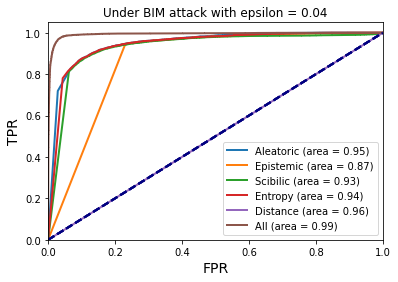

In [16]:
if input_a == 5:

    #test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())
    #test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    
    #ckpt_dropout = torch.load('/content/gdrive/MyDrive/checkpointCIFAR10/LeNet_dropout.pth.tar')
    #model_dropout.load_state_dict(ckpt_dropout['state_dict'])
    #model_dropout.eval()
    #model_dropout = model_dropout.to(device)

    #test(model_dropout)

    print("Chose data attack type: \nDeepfool (1)\nFGSM  (2)\nBIM  (3)\nCW  (4)\nPGD  (5)\n")

    input_c = int(input())

    if input_c == 1:
        attack_type = "Deepfool"
    elif input_c == 2:
        attack_type = "FGSM"
    elif input_c == 3:
        attack_type = "BIM"
    elif input_c == 4:
        attack_type = "CW"
    elif input_c == 5:
        attack_type = "PGD"

    directory = '/content/gdrive/MyDrive/checkpointCIFAR10/' + attack_type

    if not os.path.exists(directory):
        os.makedirs(directory)

    print("Enter epsilon value : \n")

    eps = float(input())
    eps_str = str(int((eps+0.0000001)*100))

    print("Chosen attack type is ", attack_type)
    print("Chosen epsilon is ", eps)

    train_data = f"/content/gdrive/MyDrive/checkpointCIFAR10/all_numpy_{attack_type}_0{eps_str}.npy"
    tail = f"_{attack_type}_0{eps_str}.npy"


    train_data_all_numpy = np.load(train_data)
    train_data_all_numpy_shuffled = shuffle(train_data_all_numpy, random_state=0)

    cols = [[0], [1], [2], [3], [5], [0, 1, 2, 3, 5]]

    fpr_list = ["fpr_aleatoric", "fpr_epistemic", "fpr_scibilic", "fpr_entropy", "fpr_distance", "fpr_All"]

    tpr_list = ["tpr_aleatoric", "tpr_epistemic", "tpr_scibilic", "tpr_entropy", "fpr_distance", "tpr_All"]

    roc_auc_list = ["roc_auc_aleatoric", "roc_auc_epistemic", "roc_auc_scibilic", "roc_auc_entropy", "roc_auc_distance", "roc_auc_All"]

    legend_label = ['Aleatoric', 'Epistemic', 'Scibilic', 'Entropy', 'Distance', 'All']

    for i,c in enumerate(cols):

        col_idx = np.array(c)

        X_train = train_data_all_numpy_shuffled[:, col_idx]
        y_train = train_data_all_numpy_shuffled[:, -1]

        scaler = StandardScaler()

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)

        logisticRegr = LogisticRegressionCV()
        lr = logisticRegr.fit(X_train, y_train)

        probs = lr.predict_proba(X_train)
        preds = probs[:, 1]

        fpr, tpr, threshold = metrics.roc_curve(y_train, preds)

        roc_auc = []
        roc_auc.append(metrics.auc(fpr, tpr))

        fpr = np.array(fpr)
        np.save("/content/gdrive/MyDrive/checkpointCIFAR10/" + attack_type + "/" + fpr_list[i] + tail, fpr)

        tpr = np.array(tpr)
        np.save("/content/gdrive/MyDrive/checkpointCIFAR10/" + attack_type + "/" + tpr_list[i] + tail, tpr)

        roc_auc = np.array(roc_auc)
        np.save("/content/gdrive/MyDrive/checkpointCIFAR10/" + attack_type + "/" + roc_auc_list[i] + tail, roc_auc)

    cols = [[0], [1], [2], [3], [5], [0, 1, 2, 3, 5]]

    fpr_list = ["fpr_aleatoric", "fpr_epistemic", "fpr_scibilic", "fpr_entropy", "fpr_distance", "fpr_All"]

    tpr_list = ["tpr_aleatoric", "tpr_epistemic", "tpr_scibilic", "tpr_entropy", "fpr_distance", "tpr_All"]

    roc_auc_list = ["roc_auc_aleatoric", "roc_auc_epistemic", "roc_auc_scibilic", "roc_auc_entropy", "roc_auc_distance", "roc_auc_All"]

    legend_label = ['Aleatoric', 'Epistemic', 'Scibilic', 'Entropy', 'Distance', 'All']

    for i,c in enumerate(cols):
        lw = 2
        fpr = np.load("/content/gdrive/MyDrive/checkpointCIFAR10/" + attack_type + "/" + fpr_list[i] + tail)
        tpr = np.load("/content/gdrive/MyDrive/checkpointCIFAR10/" + attack_type + "/" + tpr_list[i] + tail)
        roc_auc = np.load("/content/gdrive/MyDrive/checkpointCIFAR10/" + attack_type + "/" + roc_auc_list[i] + tail)[0]

        plt.plot(fpr, tpr,lw=lw, label='%s (area = %0.2f)' % (legend_label[i], roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FPR', fontsize=14)
        plt.ylabel('TPR', fontsize=14)
        plt.legend(loc="lower right")
        plt.title(f'Under {attack_type} attack with epsilon = {str(eps)}')
    plt.show()
